In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn import preprocessing
from google.colab import drive
from IPython.core.display import Latex
import random
from time import sleep
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

from sklearn import svm
from scipy.spatial import KDTree
from sklearn import preprocessing
from skimage.transform import resize
from sklearn.linear_model import LogisticRegression
from skimage.io import imread, imshow, imread_collection
from scipy import stats
from scipy.spatial import KDTree
from sklearn.utils import resample
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)}) 
np.random.seed(7)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def reduceDimension(originalX):
  pca_dims = PCA()
  pca_dims.fit(originalX)
  cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
  d = np.argmax(cumsum >= 0.95) + 1
  pca = PCA(n_components = d)
  reducedX = pca.fit_transform(originalX)
  recoveredX = pca.inverse_transform(reducedX)
  return reducedX, recoveredX

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/mnist_sign_data/sign_mnist_whole.csv')
X = df.iloc[:,1:]
Y = df.iloc[:,0:1]
X.head()
Y.head()
reducedX, recoveredX = reduceDimension(X)
reduced = reducedX
print(reducedX[2].shape)

x = np.c_[df.iloc[:,0:1],reduced]
y = (df[['label']]).to_numpy()


(115,)


In [ ]:
#KNN Implementado usando KDTree

def train_knn(data, categories):
  """
  Parameters
  ----------
  array : np.array
      array de puntos a entrenar
  categories : np.array
      array de categoria que representan los puntos
  Returns
  -------
  KDTree
      retorna arbol balanceado para mejorar los tiempos de busqueda
  """
  kdtree = KDTree(data, balanced_tree=True)
  return kdtree

def query_knn(point, k, categories, tree):
  """
  Parameters
  ----------
  point : np.array
      array punto que se buscara en el arbol
  k : int
      numero de elementos cercanos que se extraeran
  categories : int
      categorias que representan los puntos
  tree : int
      arbol entrenado de donde se buscara el elemento
  Returns
  -------
  np.array
      results son los indices y k_dist las distancias
  """
  k_dist, k_found = tree.query(point, k=k, workers=4)
  results = []
  for found in k_found:
    results.append(categories[found])
  return results, k_dist


def query_category(point, k, categories, tree):
  """
  Parameters
  ----------
  point : np.array
      array punto que se buscara en el arbol
  k : int
      numero de elementos cercanos que se extraeran
  categories : int
      categorias que representan los puntos
  tree : int
      arbol entrenado de donde se buscara el elemento
  Returns
  -------
  int
      retornal el elemento que es la moda
  """
  results, dist = query_knn(point, k, categories, tree)
  mode = stats.mode(results)
  return mode[0][0]

def query_radius(point, radius, categories, tree):
  """
  Parameters
  ----------
  point : np.array
      array punto que se buscara en el arbol
  radius : int
      radio del cual se extraeran los puntos
  categories : int
      categorias que representan los puntos
  tree : int
      arbol entrenado de donde se buscara el elemento
  Returns
  -------
  np.array
      results son los indices y k_dist las distancias
  """
  k_dist, k_found = tree.query_ball(point, r=radius)
  results = []
  for found in k_found:
    results.append(categories[found])
  return results, k_dist

In [ ]:
# K fold

def get_k_fold(array, k , fold):
  """
  Parameters
  ----------
  array : numpy array
      array que se usara en las pruebas
  k : int
      numero de grupos que se crearan
  fold : int
      numero de grupo que se obtendra
  Returns
  -------
  tuple
      train y test, que se usaran en los experimentos
  """
  size_group = int(array.shape[0]/k)
  start = size_group * fold
  end = size_group * (fold+1)
  print(start)
  print(end)
  test = array[start:end,:]
  train_start = array[0:start,:]
  train_end = array[end+1:,:]
  train = np.r_[train_start,train_end]
  return train, test


In [ ]:
# Bootstrap

# Idea obtenida de https://machinelearningmastery.com/a-gentle-introduction-to-the-bootstrap-method/
def get_bootstrap(array):
  """
  Parameters
  ----------
  array : numpy array
      array que se usara en las pruebas
  size : int
      tamaño del train, el resto se usa para test
  Returns
  -------
  tuple
      train y test, que se usaran en los experimentos
  """
  index = np.random.randint(x.shape[0], size=x.shape[0])
  train = x[index, :]
  test_index = []
  for val in range(array.shape[0]):
    if not val in index:
      test_index.append(val)
  test = x[test_index,:]
  return train, test

In [ ]:
# Randomize X
np.random.shuffle(x)

In [ ]:
def test_knn_k_fold(array, n_k, knn):
  rows, cols = 25,25
  results = [([0]*cols) for i in range(rows)]
  presicion_macro = []
  presicion_micro = []
  presicion_weighted = []
  recall_macro = []
  recall_micro = []
  recall_weighted = []
  F1_macro = []
  F1_micro = []
  F1_weighted = []
  auc = []
  for i in range(n_k):
    predicted_list = []
#    print("Fold: ", i)
    train_i, test_i = get_k_fold(array, n_k, i)
    assert(array.shape[1] == test_i.shape[1])
    assert(train_i.shape[1] == test_i.shape[1])
    x_train = train_i[:,1:]
    y_train = train_i[:,0]
    x_test = test_i[:,1:]
    y_test = test_i[:,0]
    fit_model = train_knn(x_train,y_train)
    for point in range(y_test.shape[0]):
      predicted = query_category(x_test[point,:], knn, y_train, fit_model)
      real = y_test[point]
 #     print(real)
 #     print(predicted)
 #     print("Valor real = ", real, " Valor predecido = ", predicted)
 #     print("Fold: ",i, "Iteracion: ", point, "Puntos Totales: ", y_test.shape[0])
      predicted_list.append(predicted)
    presicion_macro.append(precision_score(y_test, predicted_list, average='macro'))
    presicion_micro.append(precision_score(y_test, predicted_list, average='micro'))
    presicion_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
    recall_macro.append(precision_score(y_test, predicted_list, average='macro'))
    recall_micro.append(precision_score(y_test, predicted_list, average='micro'))
    recall_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
    F1_macro.append(precision_score(y_test, predicted_list, average='macro'))
    F1_micro.append(precision_score(y_test, predicted_list, average='micro'))
    F1_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
  mean_presicion_macro = np.mean(presicion_macro)
  mean_presicion_micro = np.mean(presicion_micro)
  mean_presicion_weight = np.mean(presicion_weighted)
  mean_recall_macro = np.mean(recall_macro)
  mean_recall_micro = np.mean(recall_micro)
  mean_recall_weight = np.mean(recall_weighted)
  mean_F1_macro = np.mean(F1_macro)
  mean_F1_micro = np.mean(F1_micro)
  mean_F1_weight = np.mean(F1_weighted)
  return mean_presicion_macro, mean_presicion_micro, mean_presicion_weight, mean_recall_macro, mean_recall_micro, mean_F1_macro, mean_recall_weight, mean_F1_micro, mean_F1_weight
  



In [ ]:
x_reduced = (x)

for K_fold in [3,5,7,10]:
  for knn_val in [10,20,40,80]:
    p_macro, p_micro, p_weight, r_macro, r_micro, r_weight, F1_macro, F1_micro, F1_weight = test_knn_k_fold(x_reduced, K_fold, knn_val )
    print("Presicion Macro: ", p_macro, "with ", K_fold, " folds", "with ", knn_val, " Ks")
    print("Presicion Micro: ", p_micro, "with ", K_fold, " folds", "with ", knn_val, " Ks")
    print("Presicion weighted: ", p_weight, "with ", K_fold, " folds", "with ", knn_val, " Ks")
    print("Recall Macro: ", r_macro, "with ", K_fold, " folds", "with ", knn_val, " Ks")
    print("Recall Micro: ", r_micro, "with ", K_fold, " folds", "with ", knn_val, " Ks")
    print("Recall weighted: ", r_weight, "with ", K_fold, " folds", "with ", knn_val, " Ks")
    print("F1 Macro: ", F1_macro, "with ", K_fold, " folds", "with ", knn_val, " Ks")
    print("F1 Micro: ", F1_micro, "with ", K_fold, " folds", "with ", knn_val, " Ks")
    print("F1 weighted: ", F1_weight, "with ", K_fold, " folds", "with ", knn_val, " Ks")


0
11542
11542
23084
23084
34626
Presicion Macro:  0.9812594141589597 with  3  folds with  10  Ks
Presicion Micro:  0.9810835788136082 with  3  folds with  10  Ks
Presicion weighted:  0.9813390863704913 with  3  folds with  10  Ks
Recall Macro:  0.9812594141589597 with  3  folds with  10  Ks
Recall Micro:  0.9810835788136082 with  3  folds with  10  Ks
Recall weighted:  0.9812594141589597 with  3  folds with  10  Ks
F1 Macro:  0.9813390863704913 with  3  folds with  10  Ks
F1 Micro:  0.9810835788136082 with  3  folds with  10  Ks
F1 weighted:  0.9813390863704913 with  3  folds with  10  Ks
0
11542
11542
23084
23084
34626
Presicion Macro:  0.9576372541506579 with  3  folds with  20  Ks
Presicion Micro:  0.9568243516432738 with  3  folds with  20  Ks
Presicion weighted:  0.957822332554462 with  3  folds with  20  Ks
Recall Macro:  0.9576372541506579 with  3  folds with  20  Ks
Recall Micro:  0.9568243516432738 with  3  folds with  20  Ks
Recall weighted:  0.9576372541506579 with  3  folds

In [ ]:
def test_knn_bootstrap(array, repetitions, knn):
  rows, cols = 25,25
  results = [([0]*cols) for i in range(rows)]
  presicion_macro = []
  presicion_micro = []
  presicion_weighted = []
  recall_macro = []
  recall_micro = []
  recall_weighted = []
  F1_macro = []
  F1_micro = []
  F1_weighted = []
  auc = []
  for i in range(repetitions):
    predicted_list = []
#    print("Fold: ", i)
    train_i, test_i = get_bootstrap(array)
    print("shape_train", train_i.shape, " shape_test", test_i.shape)
    assert(array.shape[1] == test_i.shape[1])
    assert(train_i.shape[1] == test_i.shape[1])
    x_train = train_i[:,1:]
    y_train = train_i[:,0]
    x_test = test_i[:,1:]
    y_test = test_i[:,0]
    fit_model = train_knn(x_train,y_train)
    for point in range(y_test.shape[0]):
      predicted = query_category(x_test[point,:], knn, y_train, fit_model)
      real = y_test[point]
 #     print(real)
 #     print(predicted)
 #     print("Valor real = ", real, " Valor predecido = ", predicted)
 #     print("Fold: ",i, "Iteracion: ", point, "Puntos Totales: ", y_test.shape[0])
      predicted_list.append(predicted)
    presicion_macro.append(precision_score(y_test, predicted_list, average='macro'))
    presicion_micro.append(precision_score(y_test, predicted_list, average='micro'))
    presicion_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
    recall_macro.append(precision_score(y_test, predicted_list, average='macro'))
    recall_micro.append(precision_score(y_test, predicted_list, average='micro'))
    recall_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
    F1_macro.append(precision_score(y_test, predicted_list, average='macro'))
    F1_micro.append(precision_score(y_test, predicted_list, average='micro'))
    F1_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
  mean_presicion_macro = np.mean(presicion_macro)
  mean_presicion_micro = np.mean(presicion_micro)
  mean_presicion_weight = np.mean(presicion_weighted)
  mean_recall_macro = np.mean(recall_macro)
  mean_recall_micro = np.mean(recall_micro)
  mean_recall_weight = np.mean(recall_weighted)
  mean_F1_macro = np.mean(F1_macro)
  mean_F1_micro = np.mean(F1_micro)
  mean_F1_weight = np.mean(F1_weighted)
  return mean_presicion_macro, mean_presicion_micro, mean_presicion_weight, mean_recall_macro, mean_recall_micro, mean_F1_macro, mean_recall_weight, mean_F1_micro, mean_F1_weight
  


In [ ]:
x_reduced = (x)

for repetitions in [4,10,15,20]:
  for knn_val in [10,20,40,80]:
    p_macro, p_micro, p_weight, r_macro, r_micro, r_weight, F1_macro, F1_micro, F1_weight = test_knn_bootstrap(x_reduced, repetitions, knn_val )
    print("Presicion Macro: ", p_macro, "with ", repetitions, " repetitions with", knn_val, "K")
    print("Presicion Micro: ", p_micro, "with ", repetitions, " repetitions with", knn_val, "K")
    print("Presicion weighted: ", p_weight, "with ", repetitions, " repetitions with ", knn_val, "K")
    print("Recall Macro: ", r_macro, "with ", repetitions, " repetitions  with", knn_val, "K")
    print("Recall Micro: ", r_micro, "with ", repetitions, " repetitions with", knn_val, "K")
    print("Recall weighted: ", r_weight, "with ", repetitions, " repetitions with ", knn_val, "K")
    print("F1 Macro: ", F1_macro, "with ", repetitions, " repetitions with ", knn_val, "K")
    print("F1 Micro: ", F1_micro, "with ", repetitions, " repetitions with", knn_val, "K")
    print("F1 weighted: ", F1_weight, "with ", repetitions, " repetitions with", knn_val, "K")


shape_train (34627, 116)  shape_test (12668, 116)
shape_train (34627, 116)  shape_test (12803, 116)
shape_train (34627, 116)  shape_test (12687, 116)
shape_train (34627, 116)  shape_test (12707, 116)
Presicion Macro:  0.9850369579857953 with  4  repetitions with 10 K
Presicion Micro:  0.9849390495685832 with  4  repetitions with 10 K
Presicion weighted:  0.9850847308972913 with  4  repetitions with  10 K
Recall Macro:  0.9850369579857953 with  4  repetitions  with 10 K
Recall Micro:  0.9849390495685832 with  4  repetitions with 10 K
Recall weighted:  0.9850369579857953 with  4  repetitions with  10 K
F1 Macro:  0.9850847308972913 with  4  repetitions with  10 K
F1 Micro:  0.9849390495685832 with  4  repetitions with 10 K
F1 weighted:  0.9850847308972913 with  4  repetitions with 10 K
shape_train (34627, 116)  shape_test (12704, 116)
shape_train (34627, 116)  shape_test (12688, 116)
shape_train (34627, 116)  shape_test (12639, 116)
shape_train (34627, 116)  shape_test (12704, 116)
Presi

In [ ]:
"""
def test_desition_tree_k_fold(array, n_k):
  rows, cols = 25,25
  results = [([0]*cols) for i in range(rows)]
  presicion_macro = []
  presicion_micro = []
  presicion_weighted = []
  recall_macro = []
  recall_micro = []
  recall_weighted = []
  F1_macro = []
  F1_micro = []
  F1_weighted = []
  auc = []
  for i in range(n_k):
    predicted_list = []
#    print("Fold: ", i)
    train_i, test_i = get_k_fold(array, n_k, i)
    assert(array.shape[1] == test_i.shape[1])
    assert(train_i.shape[1] == test_i.shape[1])
    x_train = train_i[:,1:]
    y_train = train_i[:,0]
    x_test = test_i[:,1:]
    y_test = test_i[:,0]
    desitionTree = tree.DecisionTreeClassifier()
    desitionTree = desitionTree.fit(x_train, y_train)
    for point in range(y_test.shape[0]):
      predicted = desitionTree.predict([x_test[point,:]])[0]
      real = y_test[point]
 #     print(real)
 #     print(predicted)
 #     print("Valor real = ", real, " Valor predecido = ", predicted)
 #     print("Fold: ",i, "Iteracion: ", point, "Puntos Totales: ", y_test.shape[0])
      predicted_list.append(predicted)
    presicion_macro.append(precision_score(y_test, predicted_list, average='macro'))
    presicion_micro.append(precision_score(y_test, predicted_list, average='micro'))
    presicion_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
    recall_macro.append(precision_score(y_test, predicted_list, average='macro'))
    recall_micro.append(precision_score(y_test, predicted_list, average='micro'))
    recall_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
    F1_macro.append(precision_score(y_test, predicted_list, average='macro'))
    F1_micro.append(precision_score(y_test, predicted_list, average='micro'))
    F1_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
  mean_presicion_macro = np.mean(presicion_macro)
  mean_presicion_micro = np.mean(presicion_micro)
  mean_presicion_weight = np.mean(presicion_weighted)
  mean_recall_macro = np.mean(recall_macro)
  mean_recall_micro = np.mean(recall_micro)
  mean_recall_weight = np.mean(recall_weighted)
  mean_F1_macro = np.mean(F1_macro)
  mean_F1_micro = np.mean(F1_micro)
  mean_F1_weight = np.mean(F1_weighted)
  return mean_presicion_macro, mean_presicion_micro, mean_presicion_weight, mean_recall_macro, mean_recall_micro, mean_F1_macro, mean_recall_weight, mean_F1_micro, mean_F1_weight
  
"""

In [ ]:
"""
x_reduced = (x)

for repetitions in [3,5,7,10]:
  p_macro, p_micro, p_weight, r_macro, r_micro, r_weight, F1_macro, F1_micro, F1_weight = test_desition_tree_k_fold(x_reduced, repetitions)
  print("Presicion Macro: ", p_macro, "with ", repetitions, " repetitions ")
  print("Presicion Micro: ", p_micro, "with ", repetitions, " repetitions ")
  print("Presicion weighted: ", p_weight, "with ", repetitions, " repetitions")
  print("Recall Macro: ", r_macro, "with ", repetitions, " repetitions  ")
  print("Recall Micro: ", r_micro, "with ", repetitions, " repetitions")
  print("Recall weighted: ", r_weight, "with ", repetitions, " repetitions ")
  print("F1 Macro: ", F1_macro, "with ", repetitions, " repetitions ")
  print("F1 Micro: ", F1_micro, "with ", repetitions, " repetitions")
  print("F1 weighted: ", F1_weight, "with ", repetitions, " repetitions")
"""

In [ ]:
def test_desition_tree_k_fold(array, n_k, criterion, splitter):
  rows, cols = 25,25
  results = [([0]*cols) for i in range(rows)]
  presicion_macro = []
  presicion_micro = []
  presicion_weighted = []
  recall_macro = []
  recall_micro = []
  recall_weighted = []
  F1_macro = []
  F1_micro = []
  F1_weighted = []
  auc = []
  for i in range(n_k):
    predicted_list = []
#    print("Fold: ", i)
    train_i, test_i = get_k_fold(array, n_k, i)
    assert(array.shape[1] == test_i.shape[1])
    assert(train_i.shape[1] == test_i.shape[1])
    x_train = train_i[:,1:]
    y_train = train_i[:,0]
    x_test = test_i[:,1:]
    y_test = test_i[:,0]
    desitionTree = tree.DecisionTreeClassifier(splitter=splitter, criterion=criterion )
    desitionTree = desitionTree.fit(x_train, y_train)
    for point in range(y_test.shape[0]):
      predicted = desitionTree.predict([x_test[point,:]])[0]
      real = y_test[point]
 #     print(real)
 #     print(predicted)
 #     print("Valor real = ", real, " Valor predecido = ", predicted)
 #     print("Fold: ",i, "Iteracion: ", point, "Puntos Totales: ", y_test.shape[0])
      predicted_list.append(predicted)
    presicion_macro.append(precision_score(y_test, predicted_list, average='macro'))
    presicion_micro.append(precision_score(y_test, predicted_list, average='micro'))
    presicion_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
    recall_macro.append(precision_score(y_test, predicted_list, average='macro'))
    recall_micro.append(precision_score(y_test, predicted_list, average='micro'))
    recall_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
    F1_macro.append(precision_score(y_test, predicted_list, average='macro'))
    F1_micro.append(precision_score(y_test, predicted_list, average='micro'))
    F1_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
  mean_presicion_macro = np.mean(presicion_macro)
  mean_presicion_micro = np.mean(presicion_micro)
  mean_presicion_weight = np.mean(presicion_weighted)
  mean_recall_macro = np.mean(recall_macro)
  mean_recall_micro = np.mean(recall_micro)
  mean_recall_weight = np.mean(recall_weighted)
  mean_F1_macro = np.mean(F1_macro)
  mean_F1_micro = np.mean(F1_micro)
  mean_F1_weight = np.mean(F1_weighted)
  return mean_presicion_macro, mean_presicion_micro, mean_presicion_weight, mean_recall_macro, mean_recall_micro, mean_F1_macro, mean_recall_weight, mean_F1_micro, mean_F1_weight
  
x_reduced = (x)

for repetitions in [3,5,7,10]:
  p_macro, p_micro, p_weight, r_macro, r_micro, r_weight, F1_macro, F1_micro, F1_weight = test_desition_tree_k_fold(x_reduced, repetitions)
  print("Presicion Macro: ", p_macro, "with ", repetitions, " repetitions ")
  print("Presicion Micro: ", p_micro, "with ", repetitions, " repetitions ")
  print("Presicion weighted: ", p_weight, "with ", repetitions, " repetitions")
  print("Recall Macro: ", r_macro, "with ", repetitions, " repetitions  ")
  print("Recall Micro: ", r_micro, "with ", repetitions, " repetitions")
  print("Recall weighted: ", r_weight, "with ", repetitions, " repetitions ")
  print("F1 Macro: ", F1_macro, "with ", repetitions, " repetitions ")
  print("F1 Micro: ", F1_micro, "with ", repetitions, " repetitions")
  print("F1 weighted: ", F1_weight, "with ", repetitions, " repetitions")

In [ ]:
train_i, test_i = get_k_fold(x, 10, 1)
assert(x.shape[1] == test_i.shape[1])
assert(train_i.shape[1] == test_i.shape[1])
x_train = train_i[:,1:]
y_train = train_i[:,0]
x_test = test_i[:,1:]
y_test = test_i[:,0]
print("shape_train", x_train.shape, " shape_test", y_train.shape)
desitionTree = tree.DecisionTreeClassifier()
desitionTree = desitionTree.fit(x_train, y_train)
predicted = desitionTree.predict([x_test[1,:]])
real = y_test[1]
print(real)
print(predicted)


In [ ]:
"""
def test_desition_tree_bootstrap(array, n_k):
  rows, cols = 25,25
  results = [([0]*cols) for i in range(rows)]
  presicion_macro = []
  presicion_micro = []
  presicion_weighted = []
  recall_macro = []
  recall_micro = []
  recall_weighted = []
  F1_macro = []
  F1_micro = []
  F1_weighted = []
  auc = []
  for i in range(n_k):
    predicted_list = []
#    print("Fold: ", i)
    train_i, test_i = get_bootstrap(array)
    assert(array.shape[1] == test_i.shape[1])
    assert(train_i.shape[1] == test_i.shape[1])
    x_train = train_i[:,1:]
    y_train = train_i[:,0]
    x_test = test_i[:,1:]
    y_test = test_i[:,0]
    desitionTree = tree.DecisionTreeClassifier()
    desitionTree = desitionTree.fit(x_train, y_train)
    for point in range(y_test.shape[0]):
      predicted = desitionTree.predict([x_test[point,:]])[0]
      real = y_test[point]
 #     print(real)
 #     print(predicted)
 #     print("Valor real = ", real, " Valor predecido = ", predicted)
 #     print("Fold: ",i, "Iteracion: ", point, "Puntos Totales: ", y_test.shape[0])
      predicted_list.append(predicted)
    presicion_macro.append(precision_score(y_test, predicted_list, average='macro'))
    presicion_micro.append(precision_score(y_test, predicted_list, average='micro'))
    presicion_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
    recall_macro.append(precision_score(y_test, predicted_list, average='macro'))
    recall_micro.append(precision_score(y_test, predicted_list, average='micro'))
    recall_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
    F1_macro.append(precision_score(y_test, predicted_list, average='macro'))
    F1_micro.append(precision_score(y_test, predicted_list, average='micro'))
    F1_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
  mean_presicion_macro = np.mean(presicion_macro)
  mean_presicion_micro = np.mean(presicion_micro)
  mean_presicion_weight = np.mean(presicion_weighted)
  mean_recall_macro = np.mean(recall_macro)
  mean_recall_micro = np.mean(recall_micro)
  mean_recall_weight = np.mean(recall_weighted)
  mean_F1_macro = np.mean(F1_macro)
  mean_F1_micro = np.mean(F1_micro)
  mean_F1_weight = np.mean(F1_weighted)
  return mean_presicion_macro, mean_presicion_micro, mean_presicion_weight, mean_recall_macro, mean_recall_micro, mean_F1_macro, mean_recall_weight, mean_F1_micro, mean_F1_weight
"""  


In [ ]:
"""
for repetitions in [4,10,15,20]:
    p_macro, p_micro, p_weight, r_macro, r_micro, r_weight, F1_macro, F1_micro, F1_weight = test_desition_tree_bootstrap(x_reduced, repetitions)
    print("Presicion Macro: ", p_macro, "with ", repetitions, " repetitions")
    print("Presicion Micro: ", p_micro, "with ", repetitions, " repetitions")
    print("Presicion weighted: ", p_weight, "with ", repetitions, " repetitions")
    print("Recall Macro: ", r_macro, "with ", repetitions, " repetitions")
    print("Recall Micro: ", r_micro, "with ", repetitions, " repetitions")
    print("Recall weighted: ", r_weight, "with ", repetitions, " repetitions")
    print("F1 Macro: ", F1_macro, "with ", repetitions, " repetitions")
    print("F1 Micro: ", F1_micro, "with ", repetitions, " repetitions")
    print("F1 weighted: ", F1_weight, "with ", repetitions, " repetitions")
"""

In [ ]:
def test_desition_tree_bootstrap_crit(array, n_k, criterion, splitter):
  rows, cols = 25,25
  results = [([0]*cols) for i in range(rows)]
  presicion_macro = []
  presicion_micro = []
  presicion_weighted = []
  recall_macro = []
  recall_micro = []
  recall_weighted = []
  F1_macro = []
  F1_micro = []
  F1_weighted = []
  auc = []
  for i in range(n_k):
    predicted_list = []
#    print("Fold: ", i)
    train_i, test_i = get_bootstrap(array)
    assert(array.shape[1] == test_i.shape[1])
    assert(train_i.shape[1] == test_i.shape[1])
    x_train = train_i[:,1:]
    y_train = train_i[:,0]
    x_test = test_i[:,1:]
    y_test = test_i[:,0]
    desitionTree = tree.DecisionTreeClassifier(splitter=splitter, criterion=criterion )
    desitionTree = desitionTree.fit(x_train, y_train)
    for point in range(y_test.shape[0]):
      predicted = desitionTree.predict([x_test[point,:]])[0]
      real = y_test[point]
 #     print(real)
 #     print(predicted)
 #     print("Valor real = ", real, " Valor predecido = ", predicted)
 #     print("Fold: ",i, "Iteracion: ", point, "Puntos Totales: ", y_test.shape[0])
      predicted_list.append(predicted)
    presicion_macro.append(precision_score(y_test, predicted_list, average='macro'))
    presicion_micro.append(precision_score(y_test, predicted_list, average='micro'))
    presicion_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
    recall_macro.append(precision_score(y_test, predicted_list, average='macro'))
    recall_micro.append(precision_score(y_test, predicted_list, average='micro'))
    recall_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
    F1_macro.append(precision_score(y_test, predicted_list, average='macro'))
    F1_micro.append(precision_score(y_test, predicted_list, average='micro'))
    F1_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
  mean_presicion_macro = np.mean(presicion_macro)
  mean_presicion_micro = np.mean(presicion_micro)
  mean_presicion_weight = np.mean(presicion_weighted)
  mean_recall_macro = np.mean(recall_macro)
  mean_recall_micro = np.mean(recall_micro)
  mean_recall_weight = np.mean(recall_weighted)
  mean_F1_macro = np.mean(F1_macro)
  mean_F1_micro = np.mean(F1_micro)
  mean_F1_weight = np.mean(F1_weighted)
  return mean_presicion_macro, mean_presicion_micro, mean_presicion_weight, mean_recall_macro, mean_recall_micro, mean_F1_macro, mean_recall_weight, mean_F1_micro, mean_F1_weight
  
for repetitions in [4,10,15,20]:
  for spliter in ["best", "random"]:
    for criter in ["gini", "entropy"]:
      p_macro, p_micro, p_weight, r_macro, r_micro, r_weight, F1_macro, F1_micro, F1_weight = test_desition_tree_bootstrap_crit(x_reduced, repetitions,criter, spliter)
      print("Presicion Macro: ", p_macro, "with ", repetitions, " repetitions with splitter", spliter, "and criterion", criter )
      print("Presicion Micro: ", p_micro, "with ", repetitions, " repetitions with splitter", spliter, "and criterion", criter)
      print("Presicion weighted: ", p_weight, "with ", repetitions, " repetitions with splitter", spliter, "and criterion", criter)
      print("Recall Macro: ", r_macro, "with ", repetitions, " repetitions with splitter", spliter, "and criterion", criter)
      print("Recall Micro: ", r_micro, "with ", repetitions, " repetitions with splitter", spliter, "and criterion", criter)
      print("Recall weighted: ", r_weight, "with ", repetitions, " repetitions with splitter", spliter, "and criterion", criter)
      print("F1 Macro: ", F1_macro, "with ", repetitions, " repetitions with splitter", spliter, "and criterion", criter)
      print("F1 Micro: ", F1_micro, "with ", repetitions, " repetitions with splitter", spliter, "and criterion", criter)
      print("F1 weighted: ", F1_weight, "with ", repetitions, " repetition swith splitter", spliter, "and criterion", criter)

In [ ]:
"""
def test_knn_sklearn_k_fold(array, n_k, knn):
  rows, cols = 25,25
  results = [([0]*cols) for i in range(rows)]
  presicion_macro = []
  presicion_micro = []
  presicion_weighted = []
  recall_macro = []
  recall_micro = []
  recall_weighted = []
  F1_macro = []
  F1_micro = []
  F1_weighted = []
  auc = []
  for i in range(n_k):
    predicted_list = []
#    print("Fold: ", i)
    train_i, test_i = get_k_fold(array, n_k, i)
    assert(array.shape[1] == test_i.shape[1])
    assert(train_i.shape[1] == test_i.shape[1])
    x_train = train_i[:,1:]
    y_train = train_i[:,0]
    x_test = test_i[:,1:]
    y_test = test_i[:,0]
    neigh = KNeighborsClassifier(n_neighbors=knn)
    neigh.fit(x_train, y_train)
    for point in range(y_test.shape[0]):
      predicted = neigh.predict([x_test[point,:]])[0]
      real = y_test[point]
 #     print(real)
 #     print(predicted)
 #     print("Valor real = ", real, " Valor predecido = ", predicted)
 #     print("Fold: ",i, "Iteracion: ", point, "Puntos Totales: ", y_test.shape[0])
      predicted_list.append(predicted)
    presicion_macro.append(precision_score(y_test, predicted_list, average='macro'))
    presicion_micro.append(precision_score(y_test, predicted_list, average='micro'))
    presicion_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
    recall_macro.append(precision_score(y_test, predicted_list, average='macro'))
    recall_micro.append(precision_score(y_test, predicted_list, average='micro'))
    recall_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
    F1_macro.append(precision_score(y_test, predicted_list, average='macro'))
    F1_micro.append(precision_score(y_test, predicted_list, average='micro'))
    F1_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
  mean_presicion_macro = np.mean(presicion_macro)
  mean_presicion_micro = np.mean(presicion_micro)
  mean_presicion_weight = np.mean(presicion_weighted)
  mean_recall_macro = np.mean(recall_macro)
  mean_recall_micro = np.mean(recall_micro)
  mean_recall_weight = np.mean(recall_weighted)
  mean_F1_macro = np.mean(F1_macro)
  mean_F1_micro = np.mean(F1_micro)
  mean_F1_weight = np.mean(F1_weighted)
  return mean_presicion_macro, mean_presicion_micro, mean_presicion_weight, mean_recall_macro, mean_recall_micro, mean_F1_macro, mean_recall_weight, mean_F1_micro, mean_F1_weight
  
"""

In [ ]:
"""
x_reduced = (x)

for K_fold in [3,5,7,10]:
  for knn_val in [10,20,40,80]:
    p_macro, p_micro, p_weight, r_macro, r_micro, r_weight, F1_macro, F1_micro, F1_weight = test_knn_sklearn_k_fold(x_reduced, K_fold, knn_val )
    print("Presicion Macro: ", p_macro, "with ", K_fold, " folds", "with ", knn_val, " Ks")
    print("Presicion Micro: ", p_micro, "with ", K_fold, " folds", "with ", knn_val, " Ks")
    print("Presicion weighted: ", p_weight, "with ", K_fold, " folds", "with ", knn_val, " Ks")
    print("Recall Macro: ", r_macro, "with ", K_fold, " folds", "with ", knn_val, " Ks")
    print("Recall Micro: ", r_micro, "with ", K_fold, " folds", "with ", knn_val, " Ks")
    print("Recall weighted: ", r_weight, "with ", K_fold, " folds", "with ", knn_val, " Ks")
    print("F1 Macro: ", F1_macro, "with ", K_fold, " folds", "with ", knn_val, " Ks")
    print("F1 Micro: ", F1_micro, "with ", K_fold, " folds", "with ", knn_val, " Ks")
    print("F1 weighted: ", F1_weight, "with ", K_fold, " folds", "with ", knn_val, " Ks")

"""

In [ ]:
def test_knn_sklearn_k_fold(array, n_k, knn, metric):
  rows, cols = 25,25
  results = [([0]*cols) for i in range(rows)]
  presicion_macro = []
  presicion_micro = []
  presicion_weighted = []
  recall_macro = []
  recall_micro = []
  recall_weighted = []
  F1_macro = []
  F1_micro = []
  F1_weighted = []
  auc = []
  for i in range(n_k):
    predicted_list = []
#    print("Fold: ", i)
    train_i, test_i = get_k_fold(array, n_k, i)
    assert(array.shape[1] == test_i.shape[1])
    assert(train_i.shape[1] == test_i.shape[1])
    x_train = train_i[:,1:]
    y_train = train_i[:,0]
    x_test = test_i[:,1:]
    y_test = test_i[:,0]
    neigh = KNeighborsClassifier(n_neighbors=knn, metric=metric)
    neigh.fit(x_train, y_train)
    for point in range(y_test.shape[0]):
      predicted = neigh.predict([x_test[point,:]])[0]
      real = y_test[point]
 #     print(real)
 #     print(predicted)
 #     print("Valor real = ", real, " Valor predecido = ", predicted)
 #     print("Fold: ",i, "Iteracion: ", point, "Puntos Totales: ", y_test.shape[0])
      predicted_list.append(predicted)
    presicion_macro.append(precision_score(y_test, predicted_list, average='macro'))
    presicion_micro.append(precision_score(y_test, predicted_list, average='micro'))
    presicion_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
    recall_macro.append(precision_score(y_test, predicted_list, average='macro'))
    recall_micro.append(precision_score(y_test, predicted_list, average='micro'))
    recall_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
    F1_macro.append(precision_score(y_test, predicted_list, average='macro'))
    F1_micro.append(precision_score(y_test, predicted_list, average='micro'))
    F1_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
  mean_presicion_macro = np.mean(presicion_macro)
  mean_presicion_micro = np.mean(presicion_micro)
  mean_presicion_weight = np.mean(presicion_weighted)
  mean_recall_macro = np.mean(recall_macro)
  mean_recall_micro = np.mean(recall_micro)
  mean_recall_weight = np.mean(recall_weighted)
  mean_F1_macro = np.mean(F1_macro)
  mean_F1_micro = np.mean(F1_micro)
  mean_F1_weight = np.mean(F1_weighted)
  return mean_presicion_macro, mean_presicion_micro, mean_presicion_weight, mean_recall_macro, mean_recall_micro, mean_F1_macro, mean_recall_weight, mean_F1_micro, mean_F1_weight
  

x_reduced = (x)

for K_fold in [3,5,7,10]:
  for knn_val in [10,20,40,80]:
    for metric in ["l1", "l2", "manhattan", "minkowski","cityblock", "cosine", "euclidean"]:
      p_macro, p_micro, p_weight, r_macro, r_micro, r_weight, F1_macro, F1_micro, F1_weight = test_knn_sklearn_k_fold(x_reduced, K_fold, knn_val, metric )
      print("Presicion Macro: ", p_macro, "with ", K_fold, " folds", "with ", knn_val, " Ks with metric", metric)
      print("Presicion Micro: ", p_micro, "with ", K_fold, " folds", "with ", knn_val, " Ks with metric", metric)
      print("Presicion weighted: ", p_weight, "with ", K_fold, " folds", "with ", knn_val, " Ks with metric", metric)
      print("Recall Macro: ", r_macro, "with ", K_fold, " folds", "with ", knn_val, " Ks with metric", metric)
      print("Recall Micro: ", r_micro, "with ", K_fold, " folds", "with ", knn_val, " Ks with metric", metric)
      print("Recall weighted: ", r_weight, "with ", K_fold, " folds", "with ", knn_val, " Ks with metric", metric)
      print("F1 Macro: ", F1_macro, "with ", K_fold, " folds", "with ", knn_val, " Ks with metric", metric)
      print("F1 Micro: ", F1_micro, "with ", K_fold, " folds", "with ", knn_val, " Ks with metric", metric)
      print("F1 weighted: ", F1_weight, "with ", K_fold, " folds", "with ", knn_val, " Ks with metric", metric)


In [ ]:
def test_knn_sklearn_bootstrap(array, n_k, knn, metric):
  rows, cols = 25,25
  results = [([0]*cols) for i in range(rows)]
  presicion_macro = []
  presicion_micro = []
  presicion_weighted = []
  recall_macro = []
  recall_micro = []
  recall_weighted = []
  F1_macro = []
  F1_micro = []
  F1_weighted = []
  auc = []
  for i in range(n_k):
    predicted_list = []
#    print("Fold: ", i)
    train_i, test_i = get_bootstrap(array)
    assert(array.shape[1] == test_i.shape[1])
    assert(train_i.shape[1] == test_i.shape[1])
    x_train = train_i[:,1:]
    y_train = train_i[:,0]
    x_test = test_i[:,1:]
    y_test = test_i[:,0]
    neigh = KNeighborsClassifier(n_neighbors=knn, metric=metric)
    neigh.fit(x_train, y_train)
    for point in range(y_test.shape[0]):
      predicted = neigh.predict([x_test[point,:]])[0]
      real = y_test[point]
 #     print(real)
 #     print(predicted)
 #     print("Valor real = ", real, " Valor predecido = ", predicted)
 #     print("Fold: ",i, "Iteracion: ", point, "Puntos Totales: ", y_test.shape[0])
      predicted_list.append(predicted)
    presicion_macro.append(precision_score(y_test, predicted_list, average='macro'))
    presicion_micro.append(precision_score(y_test, predicted_list, average='micro'))
    presicion_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
    recall_macro.append(precision_score(y_test, predicted_list, average='macro'))
    recall_micro.append(precision_score(y_test, predicted_list, average='micro'))
    recall_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
    F1_macro.append(precision_score(y_test, predicted_list, average='macro'))
    F1_micro.append(precision_score(y_test, predicted_list, average='micro'))
    F1_weighted.append(precision_score(y_test, predicted_list, average='weighted'))
  mean_presicion_macro = np.mean(presicion_macro)
  mean_presicion_micro = np.mean(presicion_micro)
  mean_presicion_weight = np.mean(presicion_weighted)
  mean_recall_macro = np.mean(recall_macro)
  mean_recall_micro = np.mean(recall_micro)
  mean_recall_weight = np.mean(recall_weighted)
  mean_F1_macro = np.mean(F1_macro)
  mean_F1_micro = np.mean(F1_micro)
  mean_F1_weight = np.mean(F1_weighted)
  return mean_presicion_macro, mean_presicion_micro, mean_presicion_weight, mean_recall_macro, mean_recall_micro, mean_F1_macro, mean_recall_weight, mean_F1_micro, mean_F1_weight
  

x_reduced = (x)

for K_fold in [3,5,7,10]:
  for knn_val in [10,20,40,80]:
      for metric in ["cityblock", "cosine", "euclidean", "l1", "l2", "manhattan", "minkowski"]:
        p_macro, p_micro, p_weight, r_macro, r_micro, r_weight, F1_macro, F1_micro, F1_weight = test_knn_sklearn_bootstrap(x_reduced, K_fold, knn_val, metric )
        print("Presicion Macro: ", p_macro, "with ", K_fold, " folds", "with ", knn_val, " Ks with metric", metric)
        print("Presicion Micro: ", p_micro, "with ", K_fold, " folds", "with ", knn_val, " Ks with metric", metric)
        print("Presicion weighted: ", p_weight, "with ", K_fold, " folds", "with ", knn_val, " Ks with metric", metric)
        print("Recall Macro: ", r_macro, "with ", K_fold, " folds", "with ", knn_val, " Ks with metric", metric)
        print("Recall Micro: ", r_micro, "with ", K_fold, " folds", "with ", knn_val, " Ks with metric", metric)
        print("Recall weighted: ", r_weight, "with ", K_fold, " folds", "with ", knn_val, " Ks with metric", metric)
        print("F1 Macro: ", F1_macro, "with ", K_fold, " folds", "with ", knn_val, " Ks with metric", metric)
        print("F1 Micro: ", F1_micro, "with ", K_fold, " folds", "with ", knn_val, " Ks with metric", metric)
        print("F1 weighted: ", F1_weight, "with ", K_fold, " folds", "with ", knn_val, " Ks with metric", metric)


Text(0, 0.5, 'Precision')

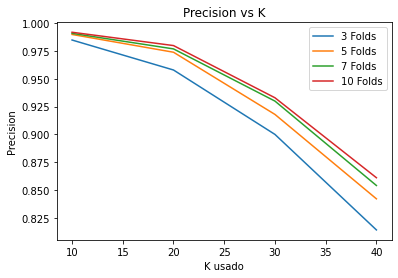

In [11]:
presicion_3F_10K = 0.985
presicion_5F_10K = 0.99
presicion_7F_10K = 0.991
presicion_10F_10K = 0.992
presicion_3F_20k = 0.958
presicion_5F_20k = 0.974
presicion_7F_20k = 0.977
presicion_10F_20k = 0.98
presicion_3F_40k = 0.9
presicion_5F_40k = 0.918
presicion_7F_40k = 0.93
presicion_10F_40k = 0.933
presicion_3F_80k = 0.814
presicion_5F_80k = 0.842
presicion_7F_80k = 0.854
presicion_10F_80k = 0.861

P3F = [presicion_3F_10K, presicion_3F_20k, presicion_3F_40k, presicion_3F_80k]
P5F = [presicion_5F_10K, presicion_5F_20k, presicion_5F_40k, presicion_5F_80k]
P7F = [presicion_7F_10K, presicion_7F_20k, presicion_7F_40k, presicion_7F_80k]
P10F = [presicion_10F_10K, presicion_10F_20k, presicion_10F_40k, presicion_10F_80k]
K_n = [10,20,30,40]
plt.title("Precision vs K")
plt.plot(K_n, P3F)
plt.plot(K_n, P5F)
plt.plot(K_n, P7F)
plt.plot(K_n, P10F)
plt.legend(["3 Folds","5 Folds","7 Folds","10 Folds"])
plt.xlabel("K usado")
plt.ylabel("Precision")


Text(0, 0.5, 'Recall')

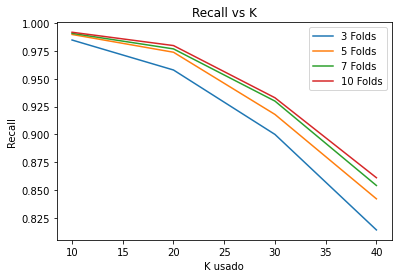

In [12]:
recall_3F_10K = 0.985
recall_5F_10K = 0.99
recall_7F_10K = 0.991
recall_10F_10K = 0.992
recall_3F_20k = 0.958
recall_5F_20k = 0.974
recall_7F_20k = 0.977
recall_10F_20k = 0.98
recall_3F_40k = 0.9
recall_5F_40k = 0.918
recall_7F_40k = 0.93
recall_10F_40k = 0.933
recall_3F_80k = 0.814
recall_5F_80k = 0.842
recall_7F_80k = 0.854
recall_10F_80k = 0.861

P3F = [recall_3F_10K, recall_3F_20k, recall_3F_40k, recall_3F_80k]
P5F = [recall_5F_10K, recall_5F_20k, recall_5F_40k, recall_5F_80k]
P7F = [recall_7F_10K, recall_7F_20k, recall_7F_40k, recall_7F_80k]
P10F = [recall_10F_10K, recall_10F_20k, recall_10F_40k, recall_10F_80k]
K_n = [10,20,30,40]
plt.title("Recall vs K")
plt.plot(K_n, P3F)
plt.plot(K_n, P5F)
plt.plot(K_n, P7F)
plt.plot(K_n, P10F)
plt.legend(["3 Folds","5 Folds","7 Folds","10 Folds"])
plt.xlabel("K usado")
plt.ylabel("Recall")


Text(0, 0.5, 'F1')

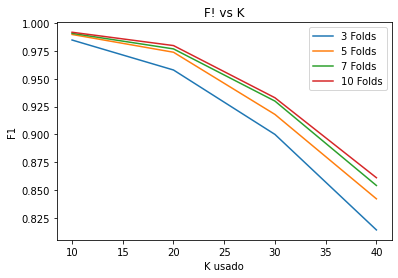

In [13]:
F1_3F_10K = 0.985
F1_5F_10K = 0.99
F1_7F_10K = 0.991
F1_10F_10K = 0.992
F1_3F_20k = 0.958
F1_5F_20k = 0.974
F1_7F_20k = 0.977
F1_10F_20k = 0.98
F1_3F_40k = 0.9
F1_5F_40k = 0.918
F1_7F_40k = 0.93
F1_10F_40k = 0.933
F1_3F_80k = 0.814
F1_5F_80k = 0.842
F1_7F_80k = 0.854
F1_10F_80k = 0.861

P3F = [F1_3F_10K, F1_3F_20k, F1_3F_40k, F1_3F_80k]
P5F = [F1_5F_10K, F1_5F_20k, F1_5F_40k, F1_5F_80k]
P7F = [F1_7F_10K, F1_7F_20k, F1_7F_40k, F1_7F_80k]
P10F = [F1_10F_10K, F1_10F_20k, F1_10F_40k, F1_10F_80k]
K_n = [10,20,30,40]
plt.title("F! vs K")
plt.plot(K_n, P3F)
plt.plot(K_n, P5F)
plt.plot(K_n, P7F)
plt.plot(K_n, P10F)
plt.legend(["3 Folds","5 Folds","7 Folds","10 Folds"])
plt.xlabel("K usado")
plt.ylabel("F1")


Text(0, 0.5, 'Precision')

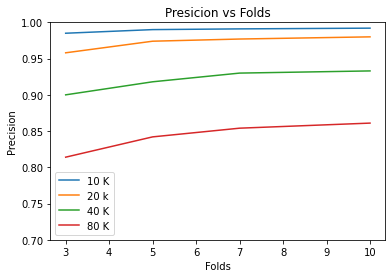

In [17]:
P10k = [F1_3F_10K, F1_5F_10K, F1_7F_10K, F1_10F_10K]
P20k = [F1_3F_20k, F1_5F_20k, F1_7F_20k, F1_10F_20k]
P40k = [F1_3F_40k, F1_5F_40k, F1_7F_40k, F1_10F_40k]
P80k = [F1_3F_80k, F1_5F_80k, F1_7F_80k, F1_10F_80k]

K_n = [3,5,7,10]
plt.title("Presicion vs Folds")
plt.plot(K_n, P10k)
plt.plot(K_n, P20k)
plt.plot(K_n, P40k)
plt.plot(K_n, P80k)
plt.ylim(0.7,1)
plt.legend(["10 K","20 k","40 K","80 K"])
plt.xlabel("Folds")
plt.ylabel("Precision")


In [ ]:
plt.title(name)
plt.plot(epochs, loss, loss_val)
plt.legend(["Loss Train","Loss Validation"])
plt.xlabel("Epochs")
plt.ylabel("Error")